In [1]:
pip install ucimlrepo

  Obtaining dependency information for ucimlrepo from https://files.pythonhosted.org/packages/3e/4a/ecc3456479d687202b34ee42317c3a63e09793c9409a720052d38356431a/ucimlrepo-0.0.3-py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from ucimlrepo import fetch_ucirepo 

#%% load Wisconsin Breast Cancer dataset using ucimlrepo
# fetch dataset 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
  
# data (as pandas dataframes) 
X = breast_cancer_wisconsin_diagnostic.data.features 
y = breast_cancer_wisconsin_diagnostic.data.targets

print(X.dtypes)
print(y.dtypes)

radius1               float64
texture1              float64
perimeter1            float64
area1                 float64
smoothness1           float64
compactness1          float64
concavity1            float64
concave_points1       float64
symmetry1             float64
fractal_dimension1    float64
radius2               float64
texture2              float64
perimeter2            float64
area2                 float64
smoothness2           float64
compactness2          float64
concavity2            float64
concave_points2       float64
symmetry2             float64
fractal_dimension2    float64
radius3               float64
texture3              float64
perimeter3            float64
area3                 float64
smoothness3           float64
compactness3          float64
concavity3            float64
concave_points3       float64
symmetry3             float64
fractal_dimension3    float64
dtype: object
Diagnosis    object
dtype: object


In [3]:
#%% analyse features
target = y['Diagnosis']
counter = Counter(target)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Class=%s, Count=%d, Percentage=%.3f%%' % (k, v, per))

Class=M, Count=212, Percentage=37.258%
Class=B, Count=357, Percentage=62.742%


In [4]:
#%% convert categorical labesl to integer
label_map={'M':1, 'B':0}
y['Diagnosis']=y['Diagnosis'].map(label_map).astype(int)

/tmp/ipykernel_47/2398945687.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['Diagnosis']=y['Diagnosis'].map(label_map).astype(int)


# Model: Logistic Regression

In [5]:
#%% split train and test sets
X = X.to_numpy()
y = y.to_numpy()
y = np.squeeze(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

#%% standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000)
model.fit(X_train, y_train)
print("Training accuracy: ", model.score(X_train, y_train))
print("Test accuracy: ", model.score(X_test, y_test))

Training accuracy:  0.98828125
Test accuracy:  0.9824561403508771


# Hyperparameter Tuning

In [10]:
#%% tune various hyperparameters using GridSearchCV()
from sklearn.model_selection import GridSearchCV

# define the parameter grid
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [100, 500, 1000]
}

# grid search for best hyperparameters with 5-fold cross-validation
model = LogisticRegression(solver='liblinear')
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [100, 500, 1000],
                         'penalty': ['l1', 'l2']})

In [11]:
# print the best hyperparameters
best_params = grid_search.best_params_

print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'C': 0.1, 'max_iter': 100, 'penalty': 'l2'}


In [12]:
results_df = pd.DataFrame(grid_search.cv_results_)
results_df_sorted = results_df.sort_values(by='mean_test_score', ascending=False)

# Extract relevant columns
param_cols = ['param_max_iter', 'param_C', 'param_penalty']
mean_test_score_col = 'mean_test_score'
std_test_score_col = 'std_test_score'

# Display average accuracy for each hyperparameter combination
print(results_df_sorted[param_cols + [mean_test_score_col] + [std_test_score_col]])

   param_max_iter param_C param_penalty  mean_test_score  std_test_score
21            500     0.1            l2         0.980430        0.013865
23           1000     0.1            l2         0.980430        0.013865
19            100     0.1            l2         0.980430        0.013865
25            100       1            l2         0.978508        0.009622
27            500       1            l2         0.978508        0.009622
29           1000       1            l2         0.978508        0.009622
28           1000       1            l1         0.978469        0.015715
24            100       1            l1         0.978469        0.015715
26            500       1            l1         0.978469        0.015715
22           1000     0.1            l1         0.976528        0.014701
18            100     0.1            l1         0.976528        0.014701
20            500     0.1            l1         0.974586        0.013333
31            100      10            l2         0.9

In [23]:
from sklearn.model_selection import KFold

# Hyperparameter values
C_vals = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
n = X_train.shape[0]

# Storing average validation accuracies for each bootsrap dataset
avg_train_accuracies, avg_val_accuracies = [[], []]

# initializing KFold
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=28)

# Non-parametric bootstrap
for C in C_vals:
    train_accs, val_accs = [[], []]
    
    # Loop over folds
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Training
        model = LogisticRegression(penalty=best_params['penalty'], C=C, 
                                   solver='liblinear', max_iter=best_params['max_iter'])
        model.fit(X_train_fold, y_train_fold)

        # Computing accuracies on the training and validation fold
        train_accs.append(model.score(X_train_fold, y_train_fold)) 
        val_accs.append(model.score(X_val_fold, y_val_fold))

    # Storing average training and validation accuracies for this C
    avg_train_accuracies.append(np.mean(train_accs)) 
    avg_val_accuracies.append(np.mean(val_accs))

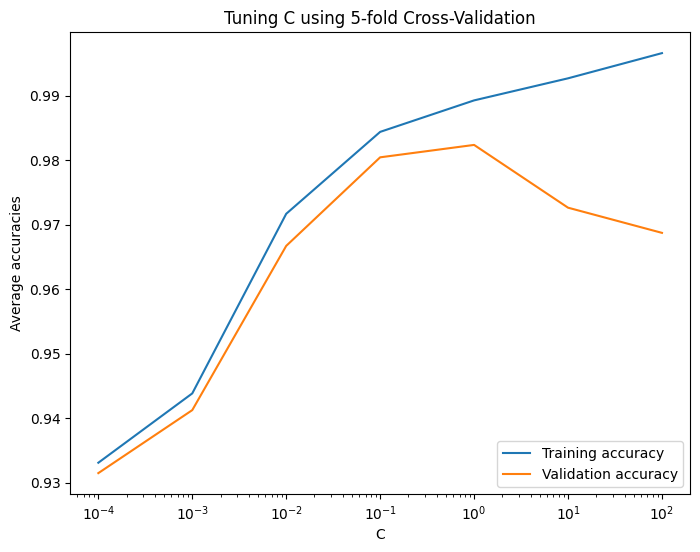

In [28]:
# Plot 
plt.figure(figsize=(8, 6))
plt.semilogx(C_vals, avg_train_accuracies, label='Training accuracy')
plt.semilogx(C_vals, avg_val_accuracies, label='Validation accuracy')
plt.xlabel(r'C')
plt.ylabel('Average accuracies')
plt.title('Tuning C using 5-fold Cross-Validation')
plt.legend(loc='lower right')

plt.savefig('LogReg_Cancer_5-foldCV.pdf', bbox_inches='tight')

---

### No regularization (not supported by 'liblinear' solver)

In [ ]:
# define the parameter grid
param_grid = {
    'solver': ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'max_iter': [100, 500, 1000]
}

# grid search for best hyperparameters with 5-fold cross-validation
model = LogisticRegression(penalty=None)
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

In [17]:
print("Best hyperparameters without regularization: ", grid_search.best_params_)

Best hyperparameters without regularization:  {'max_iter': 100, 'solver': 'saga'}


In [18]:
results_df = pd.DataFrame(grid_search.cv_results_)
results_df_sorted = results_df.sort_values(by='mean_test_score', ascending=False)

# Extract relevant columns
param_cols = ['param_solver', 'param_max_iter']
mean_test_score_col = 'mean_test_score'
std_test_score_col = 'std_test_score'

# Display average accuracy for each hyperparameter combination
print(results_df_sorted[param_cols + [mean_test_score_col] + [std_test_score_col]])

       param_solver param_max_iter  mean_test_score  std_test_score
4              saga            100         0.980430        0.013865
3               sag            100         0.976566        0.007820
9              saga            500         0.970683        0.016428
13              sag           1000         0.968742        0.020929
8               sag            500         0.968723        0.020024
14             saga           1000         0.968723        0.020024
0             lbfgs            100         0.958995        0.022672
5             lbfgs            500         0.958995        0.022672
10            lbfgs           1000         0.958995        0.022672
2   newton-cholesky            100         0.949248        0.014287
7   newton-cholesky            500         0.949248        0.014287
12  newton-cholesky           1000         0.949248        0.014287
1         newton-cg            100         0.884523        0.134435
6         newton-cg            500         0.884

---

# Bootstrap

In [29]:
# Number of bootstrap datasets
B = 300

# Storing average validation accuracies for each bootsrap dataset
bootstrap_accuracies = []

# initializing KFold
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=28)

# Non-parametric bootstrap
for b in range(B):
    # Resampling with replacement
    indices = np.random.choice(n, n, replace=True)
    X_b = X_train[indices]
    y_b = y_train[indices]
    
    accuracies = []

    # Loop over folds
    for train_index, val_index in kf.split(X_b):
        X_train_fold, X_val_fold = X_b[train_index], X_b[val_index]
        y_train_fold, y_val_fold = y_b[train_index], y_b[val_index]

        # Training
        model = LogisticRegression(penalty=best_params['penalty'], C=1, 
                                   solver='liblinear', max_iter=best_params['max_iter'])
        model.fit(X_train_fold, y_train_fold)

        # Computing accuracy on the validation fold
        accuracy = model.score(X_val_fold, y_val_fold)
        accuracies.append(accuracy)

    # Storing average validation accuracy for this bootstrap dataset
    avg_accuracy = np.mean(accuracies)
    print(f"Average validation accuracy for bootstrap dataset {b} = {avg_accuracy:.3f}")
    bootstrap_accuracies.append(avg_accuracy)

Average validation accuracy for bootstrap dataset 0 = 0.984
Average validation accuracy for bootstrap dataset 1 = 0.984
Average validation accuracy for bootstrap dataset 2 = 0.981
Average validation accuracy for bootstrap dataset 3 = 0.977
Average validation accuracy for bootstrap dataset 4 = 0.977
Average validation accuracy for bootstrap dataset 5 = 0.979
Average validation accuracy for bootstrap dataset 6 = 0.975
Average validation accuracy for bootstrap dataset 7 = 0.979
Average validation accuracy for bootstrap dataset 8 = 0.986
Average validation accuracy for bootstrap dataset 9 = 0.982
Average validation accuracy for bootstrap dataset 10 = 0.978
Average validation accuracy for bootstrap dataset 11 = 0.994
Average validation accuracy for bootstrap dataset 12 = 0.986
Average validation accuracy for bootstrap dataset 13 = 0.979
Average validation accuracy for bootstrap dataset 14 = 0.971
Average validation accuracy for bootstrap dataset 15 = 0.978
Average validation accuracy for bo

In [30]:
# Computing percentiles
mean_acc = np.mean(bootstrap_accuracies)
percentile_5 = np.percentile(bootstrap_accuracies, 5, axis=0)
percentile_95 = np.percentile(bootstrap_accuracies, 95, axis=0)

print("Mean: ", mean_acc)
print("5th percentile: ", percentile_5)
print("95th percentile: ", percentile_95)

Mean:  0.9819091947458594
5th percentile:  0.9707576622882164
95th percentile:  0.9902722253950124


In [31]:
print("Confidence interval: ", percentile_95 - percentile_5)

Confidence interval:  0.019514563106796


# Final Evaluation

In [32]:
#%% final evaluation with best hyperparameters
model = LogisticRegression(penalty=best_params['penalty'], C=1, 
                           solver='liblinear', 
                           max_iter=best_params['max_iter'])
model.fit(X_train, y_train)
print("Training accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

Training accuracy: 0.98828125
Test accuracy: 0.9824561403508771


In [33]:
#%% 
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix

# make predictions
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print or use the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9824561403508771
Precision: 1.0
Recall: 0.9411764705882353
F1 Score: 0.9696969696969697


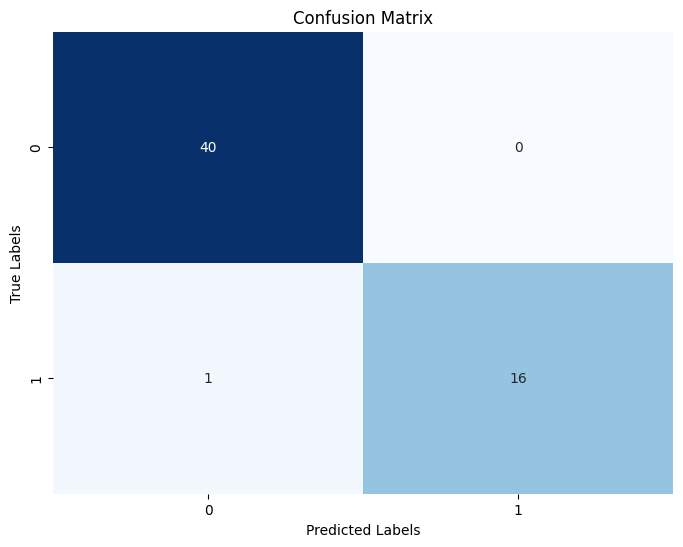

In [34]:
#%%
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.savefig('LogReg_Cancer_ConfMat.pdf', bbox_inches='tight')

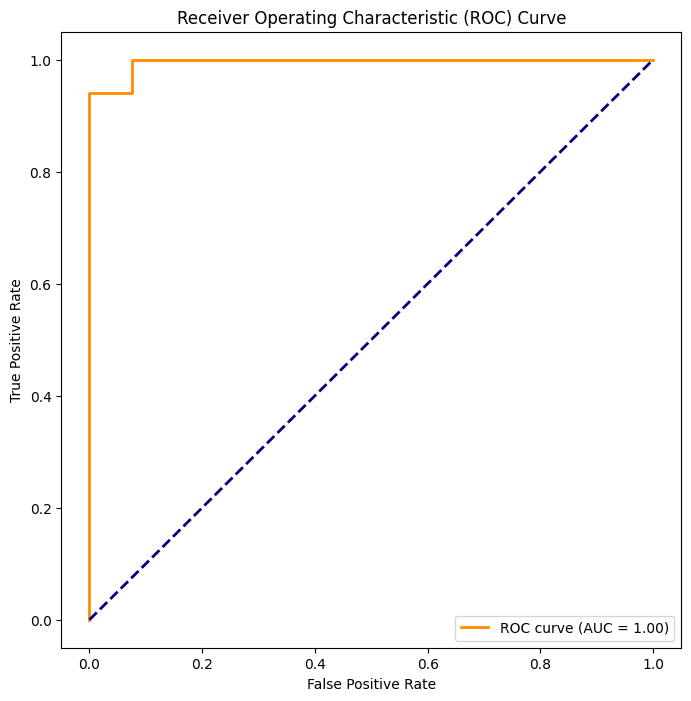

In [35]:
#%%
from sklearn.metrics import roc_curve, auc

# probability estimates for positive class
y_prob = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.savefig('LogReg_Cancer_ROC-AUC.pdf', bbox_inches='tight')